# Using audio data to transfer hidden message

In [11]:
%matplotlib inline

import pyaudio
import audioop
import numpy
import struct
import matplotlib.pyplot as plt
import numpy as np
from itertools import izip
import wave

In [12]:
audio_data = wave.open("GladOS2.wav", "rb")
chunk = 1024
frame = audio_data.readframes(chunk)
frames = []
while frame != '':    
    frames.append(frame)
    frame = audio_data.readframes(chunk)

frames = ''.join(frames)

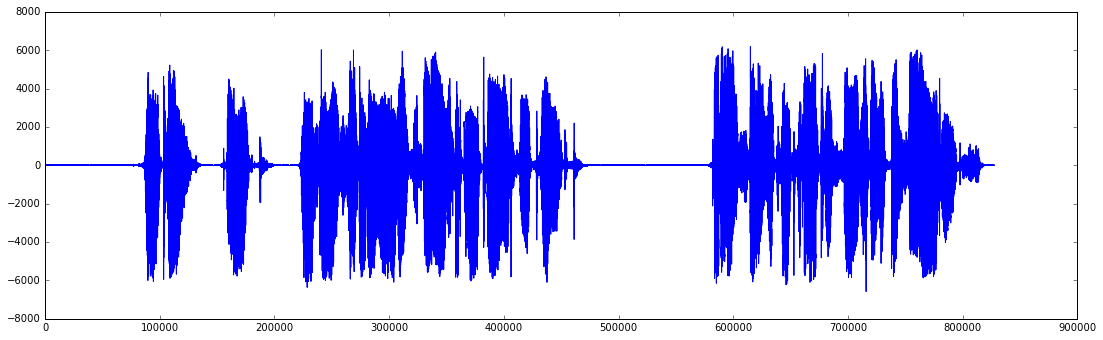

In [13]:
fig = plt.figure()
s = fig.add_subplot(111)
amplitude = numpy.fromstring(frames, numpy.int16)
s.plot(amplitude)

fig.set_size_inches(18.5, 5.5)
fig.show()
#fig.savefig('t.png')

In [14]:
p = pyaudio.PyAudio()

stream = p.open(format =
                p.get_format_from_width(audio_data.getsampwidth()),
                channels = audio_data.getnchannels(),
                rate = audio_data.getframerate(),
                output = True)

stream.write(frames)
stream.close()
p.terminate()

## Simple encoding implement

In [23]:
MESSAGE = 'I SEE YOU'

frame_blocks = [struct.unpack("<h", frames[i:i+2])[0] 
                     for i in range(0, len(frames), 2)]

def encoder(frame_stream, string):
    max_value = 2 ** 15
    max_frame = max(frame_stream)
    positive_frames = [f for f in frame_stream if f > 0]
    average = sum(positive_frames) / len(positive_frames)

    prefix_value = max_frame + ((max_value - max_frame) / 2)    
    h = len(frame_stream) / 100   
    window_size = 1
    x = 0
    
    print "H ==", h
    
    while x < len(frame_stream):
        if frame_stream[x] > average:
            char = ord(string[0]) 
            encoded_value = prefix_value + char           
            print "Encoded value {0} ==> {1}".format(char, encoded_value)            
            for y in range(x, x + window_size):                
                frame_stream[y] = prefix_value + char           
            
            string = string[1:]
            if string == '': 
                print "String was encoded"
                break
                
            x += h 
            continue
        x += 1
    
    return prefix_value, frame_stream
        
prefix, encoded_frame = encoder(frame_blocks, MESSAGE)
print "Prefix ==", prefix


H == 8273
Encoded value 73 ==> 19555
Encoded value 32 ==> 19514
Encoded value 83 ==> 19565
Encoded value 69 ==> 19551
Encoded value 69 ==> 19551
Encoded value 32 ==> 19514
Encoded value 89 ==> 19571
Encoded value 79 ==> 19561
Encoded value 85 ==> 19567
String was encoded
Prefix == 19482


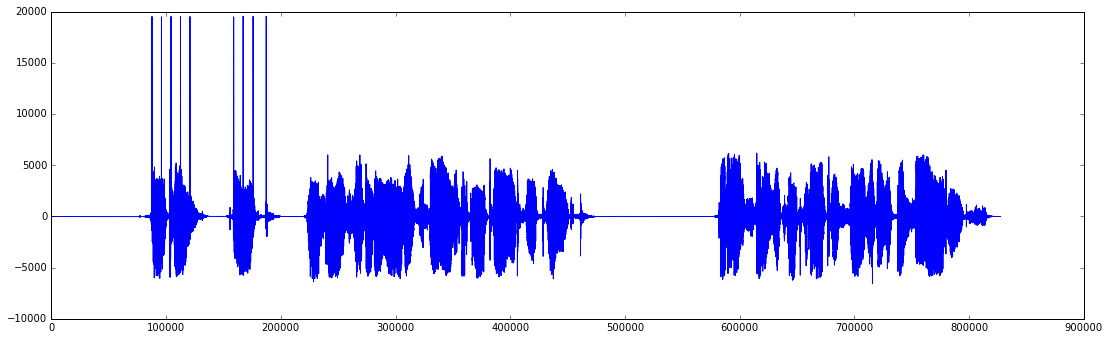

In [24]:
#fig = plt.figure()
fig = plt.figure()
s = fig.add_subplot(111)
#amplitude = numpy.asarray(encoded_frame)
fig.set_size_inches(18.5, 5.5)
s.plot(numpy.asarray(encoded_frame))
fig.show()

In [25]:
encoded_frame_stream =  [struct.pack("<h", x) for x in encoded_frame]
encoded_frame_stream = ''.join(encoded_frame_stream)

In [18]:
p = pyaudio.PyAudio()

stream = p.open(format =
                p.get_format_from_width(audio_data.getsampwidth()),
                channels = audio_data.getnchannels(),
                rate = audio_data.getframerate(),
                output = True)

stream.write(encoded_frame_stream)
stream.close()
p.terminate()

## Decode audio data and compare it with message

In [26]:
def decode(encoded_stream, prefix):
    string = ''
    for x in encoded_stream:
        if x > prefix:
            char = (x - prefix) & 0xFF
            string += chr(char)
    return string

assert decode(encoded_frame, prefix) == MESSAGE

In [20]:
FORMAT = pyaudio.paInt16
CHANNELS = audio_data.getnchannels()
RATE = audio_data.getframerate()
WAVE_OUTPUT_FILENAME = "file.wav"

audio = pyaudio.PyAudio()

waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(encoded_frame_stream)
waveFile.close()
audio.terminate()
